<a href="https://colab.research.google.com/github/BjerringNYK/BDS/blob/main/FirstEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Exploratory Data Analysis (EDA) and Visualization


## FINDEX (Global Financial Index Microdata) and it's business context

The Global Findex database is the most comprehensive dataset on adult financial behaviors worldwide, capturing insights into how individuals save, borrow, make payments, and manage financial risks. Initiated by the World Bank in 2011, the dataset is based on nationally representative surveys of over 150,000 adults across more than 140 economies. The 2021 edition provides updated indicators on the use of both formal and informal financial services.

For this analysis, we will conduct an Exploratory Data Analysis (EDA) to uncover key patterns and trends in the financial behaviors of individuals globally across regions and genders. As this analysis is undertaken by a group of finance students with a strong interest in banking and personal finance, our focus will be on examining how different demographics access and use financial services across various economies.


## 1. Data Cleaning and Manipulation

In [56]:
# Importning libraries to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


# Initially, the data couldn’t be read with UTF-8 due to special characters. Using ChatGPT we found that latin-1 supports these characters, allowing for proper file decoding.
# data = pd.read_csv('https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/FINDEX/WLD_2021_FINDEX_v03_M_csv.zip')

In [57]:
# Reading the data using the raw URL on github
data = pd.read_csv('https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/FINDEX/WLD_2021_FINDEX_v03_M_csv.zip', encoding='latin-1')

### Initial Data Structure Overview: Head, Info, Shape, Index, and Column Names

In [58]:
data.head()

,economy,economycode,regionwb,pop_adult,wpid_random,wgt,female,age,educ,inc_q,...,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,mobileowner,internetaccess,anydigpayment,merchantpay_dig,year
0,Afghanistan,AFG,South Asia,22647496.0,144274031,0.716416,2,43.0,2,4,...,4,4,4.0,1,5.0,1,2,1,0.0,2021
1,Afghanistan,AFG,South Asia,22647496.0,180724554,0.497408,2,55.0,1,3,...,4,4,2.0,4,5.0,1,2,0,0.0,2021
2,Afghanistan,AFG,South Asia,22647496.0,130686682,0.650431,1,15.0,1,2,...,4,4,4.0,4,3.0,2,2,0,0.0,2021
3,Afghanistan,AFG,South Asia,22647496.0,142646649,0.991862,2,23.0,1,4,...,4,4,2.0,4,5.0,1,2,0,0.0,2021
4,Afghanistan,AFG,South Asia,22647496.0,199055310,0.554940,1,46.0,1,1,...,4,4,4.0,4,5.0,2,2,0,0.0,2021


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143887 entries, 0 to 143886
Columns: 128 entries, economy to year
dtypes: float64(90), int64(35), object(3)
memory usage: 140.5+ MB


In [60]:
data.shape

(143887, 128)

In [61]:
data.index

RangeIndex(start=0, stop=143887, step=1)

In [62]:
data.columns

Index(['economy', 'economycode', 'regionwb', 'pop_adult', 'wpid_random', 'wgt',
       'female', 'age', 'educ', 'inc_q',
       ...
       'receive_transfers', 'receive_pension', 'receive_agriculture',
       'pay_utilities', 'remittances', 'mobileowner', 'internetaccess',
       'anydigpayment', 'merchantpay_dig', 'year'],
      dtype='object', length=128)

### Checking for missing values

In [63]:
# Do to the size of the Dataset we filter columns with missing values greater than 0. We look further into all the
# missing values with pd.set_option('display.max_rows', None) was used afterwards using pd.reset_option('display.max_rows')
pd.reset_option('display.max_rows')
missing_data = data.isnull().sum()
missing_data[missing_data > 0]

,0
regionwb,1000
age,467
emp_in,3502
urbanicity_f2f,68243
account_mob,61181
...,...
fin45_1,33106
fin45_1_China,140387
receive_agriculture,29606
remittances,29606


In [64]:
# Filtering rows where 'regionwb' is missing
missing_region = data[data['regionwb'].isnull()]

# Groupby 'economy' and count the number of missing 'regionwb' for each country
missing_by_country = missing_region.groupby('economy').size()

print(missing_by_country)

economy
Taiwan, China    1000
dtype: int64


Its clear that there are significant missing values in the dataset. However, many of these missing values result from certain follow up questions not being asked to all participants, which accounts for the bulk of the missing data. Additionally, we notice some missing information regarding the age, region, and employment status of some participants. Since the missing values in these key categories (age, and workforce status) is quite small compared to the dataset size, it has been decided to remove these rows as we don't want to simulate age or workforce status. For the missing data in region we could have used the economy/country column to fill in the correct region, but as the region is also based on high income or not we decided to remove these missing region rows as well

The columns with a high percentage of missing data (up to 90%) were removed, as they generally represent the very niche or specific follow-up questions. This simplification streamlines the dataset without affecting its overall quality, as our focus is on a broader analysis rather than specific topics like how domestic remittances were received instead looking at general saving habits as an example

In [65]:
# Removing the rows with missing values in 'regionwb', 'age', and 'emp_in'
data_cleaned = data.dropna(subset=['age', 'emp_in', 'regionwb']).copy()

# Removing columns with more than 4000 missing values
missing_threshold = 4000
cols_to_drop = data_cleaned.columns[data_cleaned.isnull().sum() > missing_threshold]

# Dropping the columns
data_cleaned = data_cleaned.drop(columns=cols_to_drop)

# Cleaned dataset info
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138973 entries, 0 to 143886
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   economy            138973 non-null  object 
 1   economycode        138973 non-null  object 
 2   regionwb           138973 non-null  object 
 3   pop_adult          138973 non-null  float64
 4   wpid_random        138973 non-null  int64  
 5   wgt                138973 non-null  float64
 6   female             138973 non-null  int64  
 7   age                138973 non-null  float64
 8   educ               138973 non-null  int64  
 9   inc_q              138973 non-null  int64  
 10  emp_in             138973 non-null  float64
 11  account            138973 non-null  int64  
 12  account_fin        138973 non-null  int64  
 13  fin2               138973 non-null  int64  
 14  fin14_1            138973 non-null  int64  
 15  fin14a             138973 non-null  int64  
 16  fin14a1

**This leaves us with a dataset of 138973 rows and 42 columns with zero missing values**.

**The remaining columns signify the following information which we will be working with to explore the dataset further:**

0. economy: The name of the country or economy.
1. economycode: ISO 3-digit code representing each economy.
2. regionwb: World Bank region classification (e.g., Sub-Saharan Africa, East
    Asia, etc.).
3.  pop_adult: The population of adults (aged 15+) in the economy.
4.  wpid_random: A unique identifier for each respondent in the dataset.
5.  wgt: Survey weight for each respondent, used to make the sample
    representative of the population.
6.  female: Gender of the respondent (1 if female, 2 if male).
7.  age: Age of the respondent.
8.  educ: Respondent’s education level form level 1 to 3
9.  inc_q: Income quintile of the respondent’s household.
10. emp_in: Employment status of the respondent.
11. account: Whether the respondent has an account at a financial institution
    or with a mobile money service provider.
12. account_fin: Whether the respondent has an account at a formal financial
    institution.
13. fin2: Has a debit card
14. fin14_1: Whether the respondent used mobile money.
15. fin14a: Made bill payments online using the Internet
16. fin14a1: Send money to a relative or friend online
    using the Internet
17. fin14b: Bought something online using the Internet
18. fin16: Saved for old age
19. fin17a: Saved using an account at a financial
    institution
20. fin20: Borrowed for medical purposes
21. fin22a: Borrowed from a financial institution
22. fin22b: Borrowed from family or friends
23. fin24: Main source of emergency funds in 30 days
24. fin30: Paid a utility bill
25. fin32: Received wage payments
26. fin37: Received a government transfer
27. fin38: Received a government pension
28. fin44a: Financially worried: old age
29. fin44b: Financially worried: medical cost
30. fin44c: Financially worried: bills
31. fin44d: Financially worried: education
32. saved: Saved money in the past 12 months.
33. borrowed: Borrowed money in the past 12 months.
34. receive_wages: Received a wage payment and method
35. receive_transfers: Received government transfers or aid payments and method
36. receive_pension: Received government pension payments. and method
37. pay_utilities: Paid utility bills and method
38. mobileowner: Whether the respondent owns a mobile phone.
39. internetaccess: Whether the respondent has access to the internet.
40. anydigpayment: Whether the respondent made any digital payment.
41. year: The year of the data collection

## Business/Reseach Context

Now that the data has been cleaned, we have a clearer understanding of the columns, allowing us to prepare the dataset for use in a business and research context. Given the nature of the data, which includes information such as respondent education level, income, savings, borrowing behavior, and access to financial services, there are several ways this dataset could be used in a business environment or by policymakers to assess the economic conditions of different regions/economies with a focus on financial inclusion.

Applications which we will examine further:  

**Customer Segmentation:** Businesses can use the data to identify different customer segments based on education, income levels, and financial behaviors such as borrowing and saving,. For example, a financial institution could target specific products to individuals based on their likelihood to save or borrow. Further, financial companies (like banks) can segment their customer base by education and income to better target savings and loan products across different regions

**Optimizing Digital Payment Services in Underserved Regions:**  Business can identify regions/economies where mobile ownership is high but digital payment adoption is low.

**Financial Inclusion Strategies:** NGOs promoting financial inclusion can use this data to identify key differences between men and women regarding access to financial services. By analyzing disparities in financial account ownership and usage, organizations can develop targeted strategies to better serve underserved women, who may face greater barriers to accessing financial institutions compared to men in these regions.


At present, many of the answers in the dataset are represented as integers. For example, the "educ" column (education level) uses integers to represent levels of education:

1 = Primary school or less
2 = Secondary school
3 = Tertiary education or more.

We are aware of these categorical representations and will ensure that their actual meanings (e.g., "Primary school," "Secondary school," etc.) are included as string labels when creating visualizations.



## 2. Descriptive Statistics

In this dataset, most of the questions were asked in a categorical format, where:

1 = Yes, the respondent can answer the question affirmatively.
2 = No, the respondent cannot answer affirmatively.
3 = Don’t know.
4 = Refused to answer.

Because the responses are categorical and not continuous, it does not make sense to calculate basic statistics like mean, median, or variance for these variables.

Instead, the descriptive statistics will focus on providing insights about the respondents themselves (e.g., age, region, gender), where it makes sense to calculate numerical summaries. For the categorical questions, the analysis will focus on frequency counts (how many respondents chose each option) and proportions (the percentage of respondents who chose each option), which are better suited to categorical data.

By exploring the frequency counts and proportions, we can gain an understanding of the distribution of responses across different categories and the key demographic information of the respondents.

Firstly, we want to look further into how the distribution of respondents by region. High-income economies are those with more than a GNI per capita of $14005 as stated by the World Bank itself.

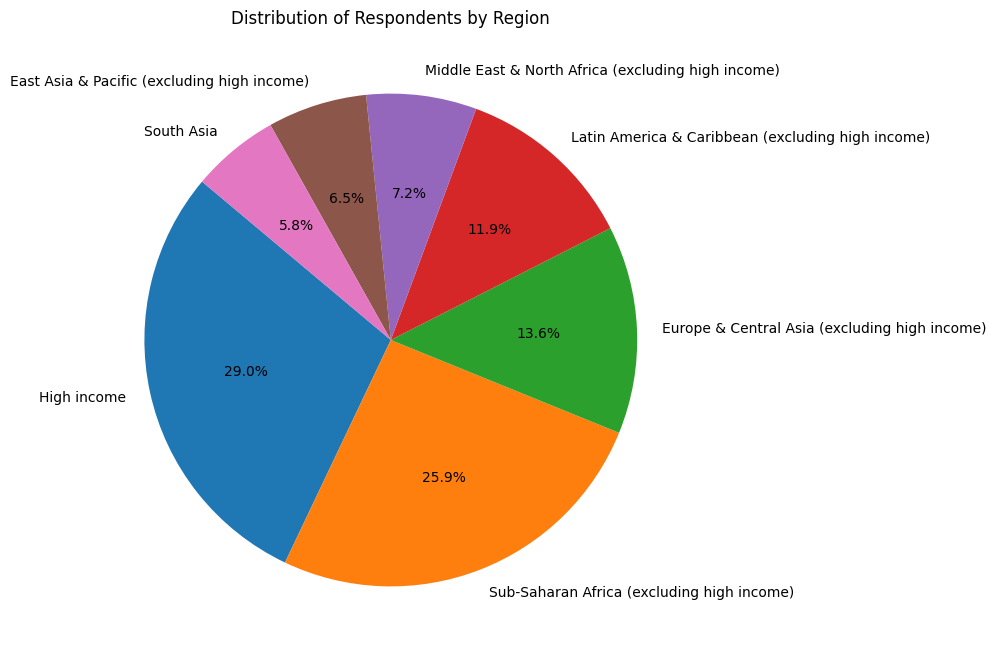

In [66]:
# Group by 'regionwb' and count the number of occurrences
region_counts = data_cleaned['regionwb'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Distribution of Respondents by Region')

# Show the plot
plt.show()

In [67]:
# Filter the dataset to only include "High income" region
high_income_countries = data_cleaned[data_cleaned['regionwb'] == 'High income']

# Get the unique list of countries in the "High income" category
high_income_country_list = high_income_countries['economy'].unique()

# Count respondents from each high-income country
high_income_country_counts = high_income_countries['economy'].value_counts()

print(high_income_country_counts)

economy
Saudi Arabia            1019
Cyprus                  1018
Japan                   1008
Belgium                 1007
Korea, Rep.             1007
Sweden                  1006
Latvia                  1005
Lithuania               1004
Denmark                 1002
United States           1001
Slovak Republic         1001
Portugal                1001
Norway                  1001
Greece                  1001
Singapore               1000
Israel                  1000
Spain                   1000
Italy                   1000
Uruguay                 1000
Finland                 1000
Chile                   1000
Estonia                 1000
France                   999
Hungary                  999
Switzerland              998
United Arab Emirates     997
Malta                    997
Austria                  997
Ireland                  996
Netherlands              996
Germany                  995
Croatia                  995
Czechia                  993
Slovenia                 993
United

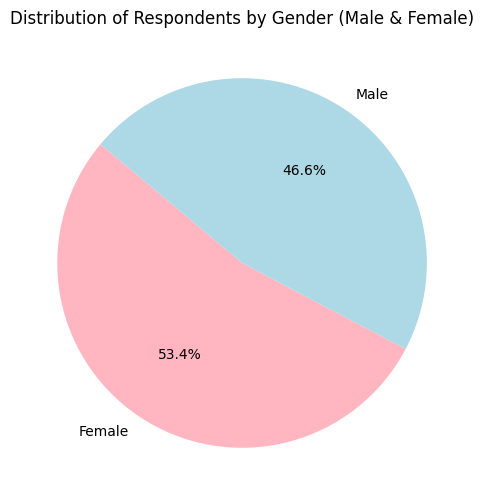

In [68]:
# We replaced the female column with a new sex column, categorizing individuals as either "Male" or "Female". The dataset only includes these two gender options, with no representation of other gender identities.
data_cleaned['female'].value_counts()

# Map 1 to 'Female' and 2 to 'Male' in the 'female' column
data_cleaned['sex'] = data_cleaned['female'].map({1: 'Female', 2: 'Male'})

# Count the occurrences of each category in the 'sex' column
sex_counts = data_cleaned['sex'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightpink', 'lightblue'])

# Add a title
plt.title('Distribution of Respondents by Gender (Male & Female)')

# Show the pie chart
plt.show()

### We have a slight overweight of female respondents

<ipython-input-69-354ecf2d551f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette="Set2")


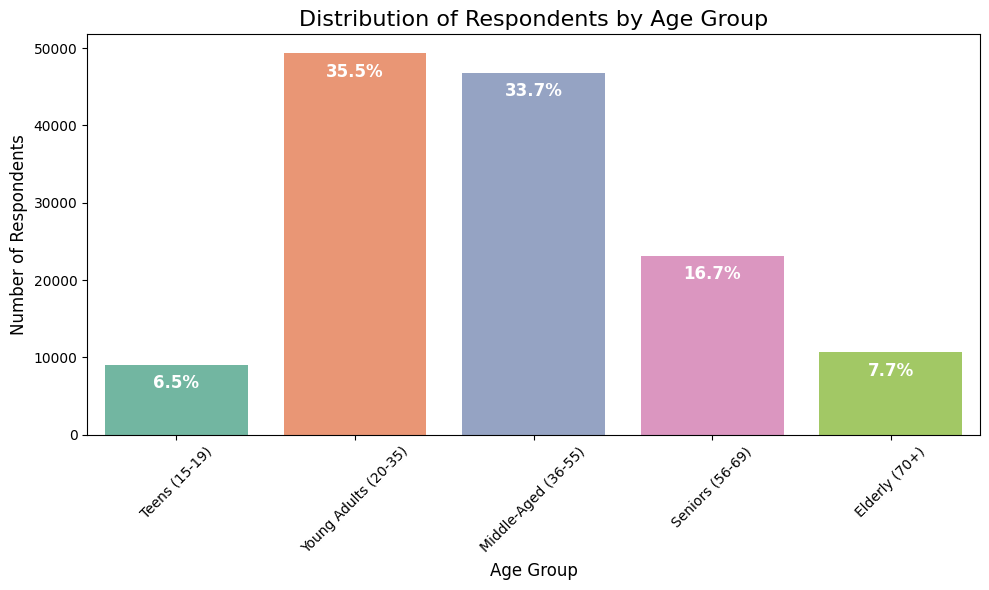

In [69]:
# Make age bins
bins = [15, 19, 35, 55, 70, 100]  # Age ranges: 0-19, 20-35, etc.
labels = ['Teens (15-19)', 'Young Adults (20-35)', 'Middle-Aged (36-55)', 'Seniors (56-69)', 'Elderly (70+)']

# Creating a new column 'age_group' that assigns age categories
data_cleaned['age_group'] = pd.cut(data_cleaned['age'], bins=bins, labels=labels, right=False)

# Check the distribution of the age groups
age_group_counts = data_cleaned['age_group'].value_counts().sort_index()

# Calculate total respondents to compute percentages
total_respondents = age_group_counts.sum()

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette="Set2")

# Add titles and labels
plt.title('Distribution of Respondents by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Respondents', fontsize=12)

# Annotate each bar with the exact count and percentage inside the bar
for i, value in enumerate(age_group_counts.values):
    percentage = (value / total_respondents) * 100
    plt.text(i, value - 3000, f'{percentage:.1f}%', ha='center', color='white', fontsize=12, fontweight='bold')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### We grouped the respondents' ages into different age categories: Teens (0-19 years), Young Adults (20-35 years), Middle-Aged (36-55 years), Seniors (56-69 years), and Elderly (70+ years). This allows us to analyze and compare financial behaviors and other characteristics across these distinct age groups, making the data more manageable and meaningful for later analysis.

<ipython-input-70-a6a664c2c47e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=educ_counts.index, y=educ_counts.values, palette="muted")


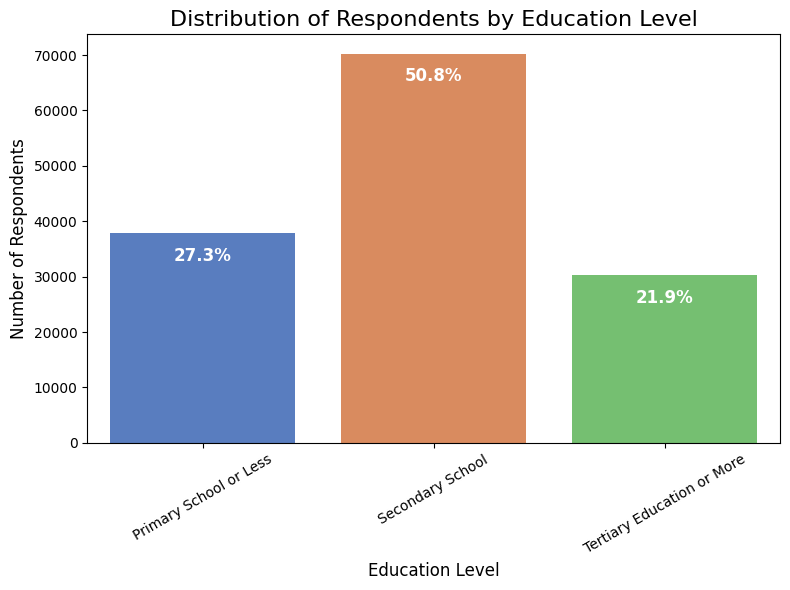

In [70]:
# Mapping the 'educ' column to more descriptive labels from the Micro Notebook
education_labels = {1: 'Primary School or Less',
                    2: 'Secondary School',
                    3: 'Tertiary Education or More'}

# Applying the mapping to the 'educ' column
data_cleaned['educ_label'] = data_cleaned['educ'].map(education_labels)

# Get the counts of each education level
educ_counts = data_cleaned['educ_label'].value_counts().sort_index()

# Calculate total respondents to compute percentages
total_respondents = educ_counts.sum()

# Create a bar plot for education levels
plt.figure(figsize=(8, 6))
sns.barplot(x=educ_counts.index, y=educ_counts.values, palette="muted")

# Add labels and title
plt.title('Distribution of Respondents by Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Number of Respondents', fontsize=12)

# Annotate each bar with the exact percentage inside the bar
for i, value in enumerate(educ_counts.values):
    percentage = (value / total_respondents) * 100
    plt.text(i, value - 5000, f'{percentage:.1f}%', ha='center', color='white', fontsize=12, fontweight='bold')

# Display the plot
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### The bar plot shows that the majority of respondents have completed Secondary School (70,234), followed by Primary School or Less (37,810), and Tertiary Education or More (30,210). This indicates that most of the sample has a medium level of education, with fewer respondents reaching higher education levels.

<ipython-input-71-4a6d0f71e647>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_account_counts.index, y=region_account_counts.values, palette="Set3")  # Using Set3 palette for different colors


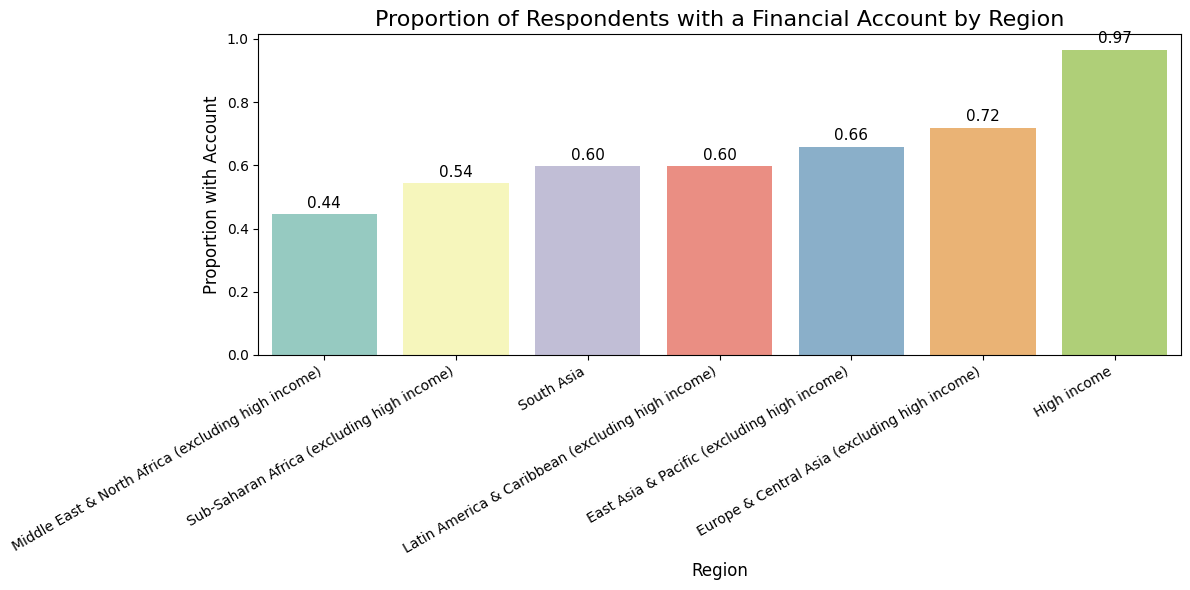

In [71]:
# Grouping the data by region and calculating the proportion of respondents with an account in each region
region_account_counts = data_cleaned.groupby('regionwb')['account'].mean().sort_values()

# Using GPT to help with a bar plot showing the proportion of respondents with an account in each region
plt.figure(figsize=(12, 6))  # Increased width for better spacing
sns.barplot(x=region_account_counts.index, y=region_account_counts.values, palette="Set3")  # Using Set3 palette for different colors

# Add labels and title
plt.title('Proportion of Respondents with a Financial Account by Region', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Proportion with Account', fontsize=12)

# Annotate each bar with the exact proportion
for i, value in enumerate(region_account_counts.values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', fontsize=11)

# Adjust x-axis labels to prevent overlapping
plt.xticks(rotation=30, ha='right', fontsize=10)  # Slightly smaller font size and less rotation

# Apply tight layout for better padding
plt.tight_layout()
plt.show()

### This chart shows financial inclusion across regions, with higher account ownership in high-income economies like High Income and Europe & Central Asia. There appears to be a link between income levels and account ownership, suggesting financial barriers in lower-income regions that we will look into further in the upcoming EDA part

## 3. Exploratory Data Analysis

### Customer Segmentation

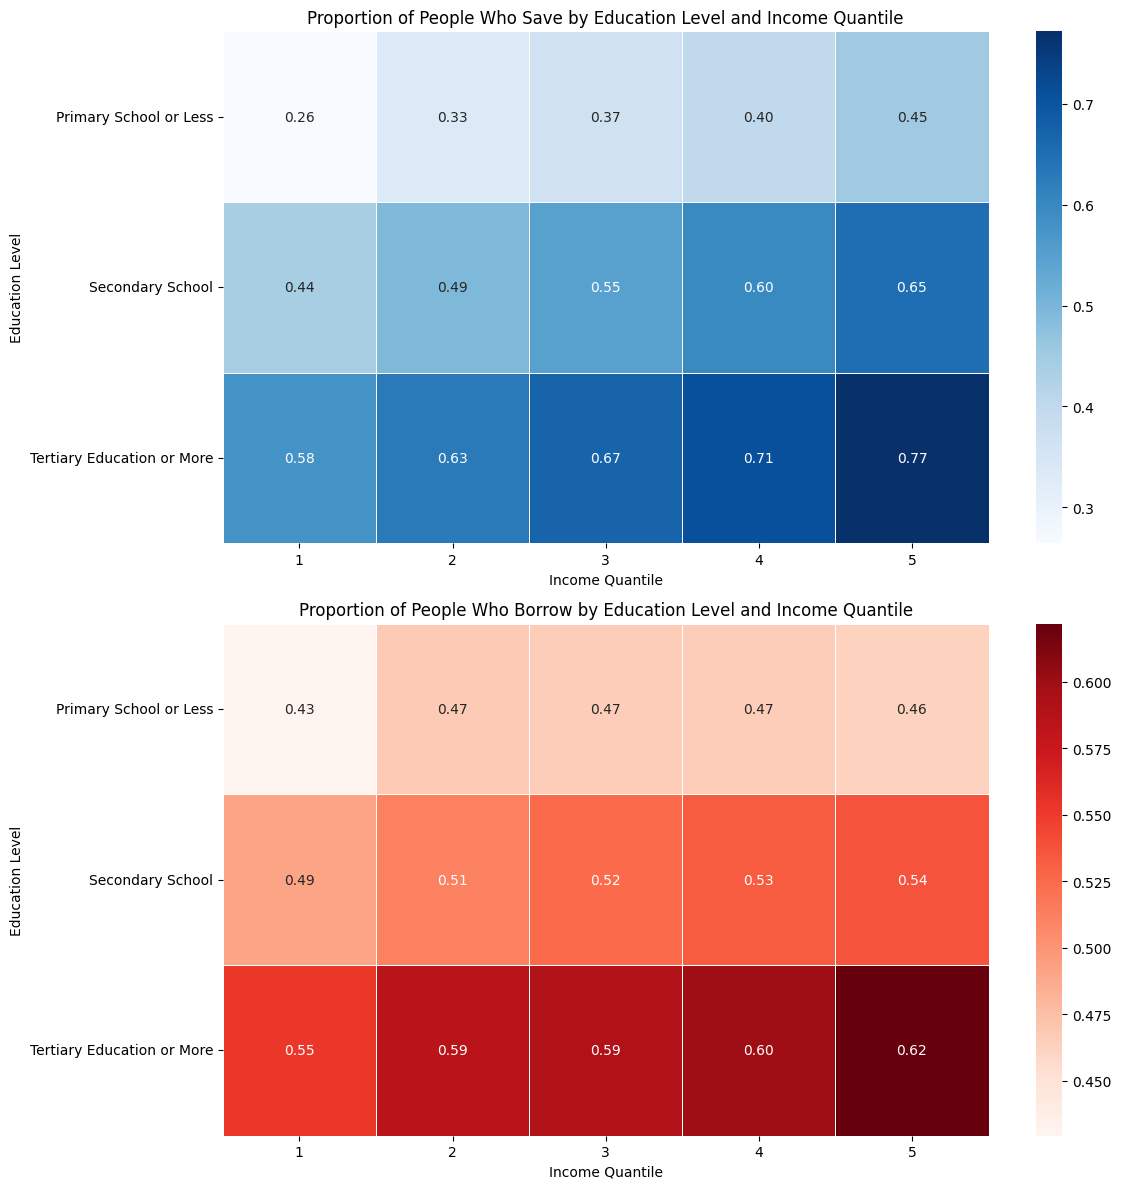

In [72]:
# Set the figure size for both plots
plt.figure(figsize=(12, 12))

# We create a cross-tabulation of education and income, looking at the proportion of people who save.
# The 'saved' column is used as the metric, and we use 'mean' to get the proportion of savers in each group.
saving_by_educ_income = pd.crosstab(data_cleaned['educ_label'], data_cleaned['inc_q'], values=data_cleaned['saved'], aggfunc='mean')

# Plotting the heatmap for saving behavior across education levels and income quantiles
plt.subplot(2, 1, 1)
sns.heatmap(saving_by_educ_income, annot=True, cmap="Blues", fmt=".2f", linewidths=.5)
plt.title('Proportion of People Who Save by Education Level and Income Quantile')
plt.xlabel('Income Quantile')
plt.ylabel('Education Level')

# We do the same as above but now analyze borrowing behavior using the 'borrowed' column.
borrowing_by_educ_income = pd.crosstab(data_cleaned['educ_label'], data_cleaned['inc_q'], values=data_cleaned['borrowed'], aggfunc='mean')

# Plotting the heatmap for borrowing behavior across education levels and income quantiles
plt.subplot(2, 1, 2)
sns.heatmap(borrowing_by_educ_income, annot=True, cmap="Reds", fmt=".2f", linewidths=.5)
plt.title('Proportion of People Who Borrow by Education Level and Income Quantile')
plt.xlabel('Income Quantile')
plt.ylabel('Education Level')
plt.tight_layout()

# Display both plots
plt.show()

Higher-income individuals tend to save more across all education levels. Those with tertiary education save the most, with savings increasing significantly from low to high income, ranging from 0.58 to 0.77. In contrast, people with primary education save less overall, even as their income rises.

When it comes to borrowing, higher-income individuals also borrow more, particularly those with tertiary education, where borrowing rates reach up to 0.62 for the wealthiest. Borrowing behavior is less predictable, showing that wealthier individuals still use loans, even though they have more savings. Interestingly, lower-educated, higher-income individuals borrow less as income rises, which could suggest limited access to credit in these groups.



<ipython-input-73-30cf16f3ea06>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mobile_ownership.index, y=mobile_ownership.values, palette="Blues_d")
<ipython-input-73-30cf16f3ea06>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=digital_payment.index, y=digital_payment.values, palette="Greens_d")


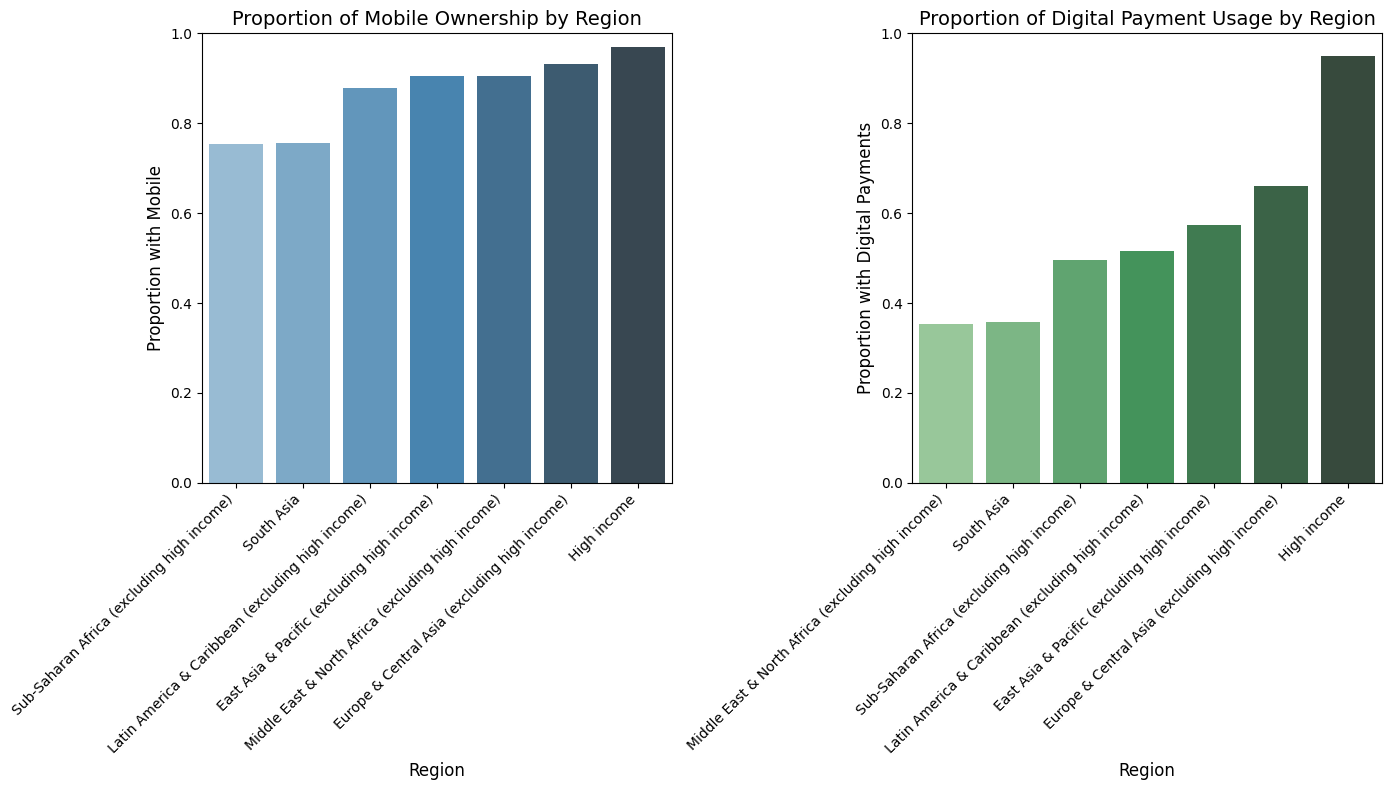

In [73]:
# Set up the figure for two bar plots side-by-side with better formatting
plt.figure(figsize=(14, 8))

# Mobile Ownership Plot
plt.subplot(1, 2, 1)
sns.barplot(x=mobile_ownership.index, y=mobile_ownership.values, palette="Blues_d")
plt.title('Proportion of Mobile Ownership by Region', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Proportion with Mobile', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, 1)  # Ensure the y-axis stays consistent

# Digital Payment Usage Plot
plt.subplot(1, 2, 2)
sns.barplot(x=digital_payment.index, y=digital_payment.values, palette="Greens_d")
plt.title('Proportion of Digital Payment Usage by Region', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Proportion with Digital Payments', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, 1)  # Keep consistent with the mobile ownership plot

# Add a tight layout to improve spacing
plt.tight_layout()

# Show the plots
plt.show()

The results show that the majority of people across most regions have access to mobile phones, indicating that mobile infrastructure is generally well-established. However, the adoption of digital payments lags behind significantly in several regions, particularly in Sub-Saharan Africa, South Asia, and parts of the Middle East & North Africa.

This gap between mobile ownership and digital payment usage highlights significant opportunities for expanding digital financial services. Many people have access to mobile phones, which could serve as a platform for digital payments, but the infrastructure or accessibility of these services seems to be underdeveloped in certain regions.

### Financial Inclusion Strategies

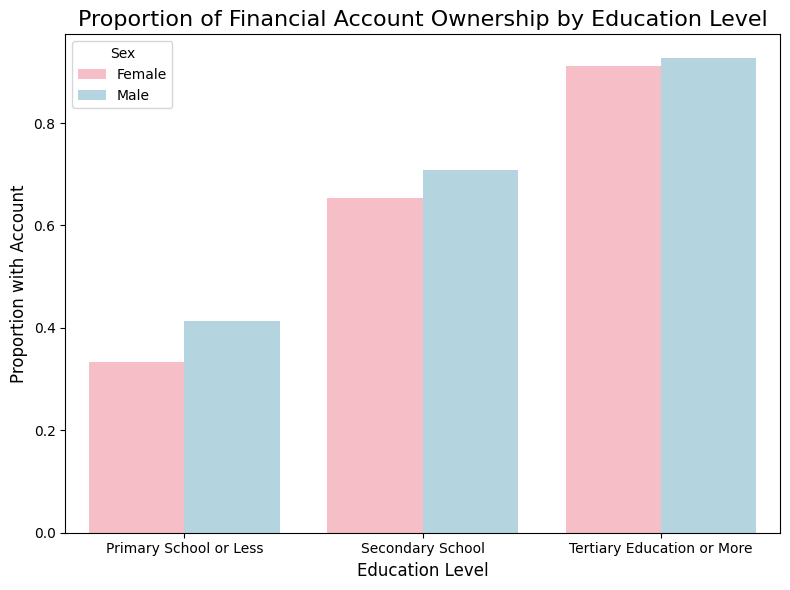

In [74]:
# Prepare data for plotting
account_data = data_cleaned.groupby(['sex', 'educ_label'])['account_fin'].mean().reset_index()

# Set up the figure size for the plot
plt.figure(figsize=(8, 6))

# Bar plot with side-by-side comparison of men and women
sns.barplot(x='educ_label', y='account_fin', hue='sex', data=account_data, palette={'Female': 'lightpink', 'Male': 'lightblue'})

# Add labels and title
plt.title('Proportion of Financial Account Ownership by Education Level', fontsize=16)
plt.ylabel('Proportion with Account', fontsize=12)
plt.xlabel('Education Level', fontsize=12)

# Show the legend
plt.legend(title='Sex')

# Display the plot
plt.tight_layout()
plt.show()

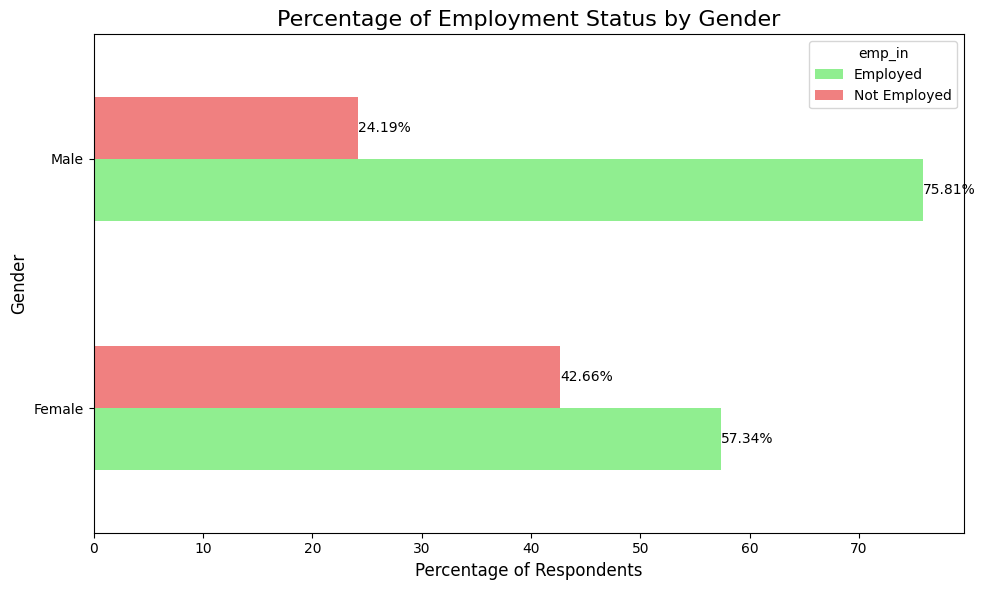

In [75]:
# Plot horizontal bar plot with the updated colors (green for employed, red for not employed)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars with updated colors
employment_percentages.plot(kind='barh', color=['lightgreen', 'lightcoral'], ax=ax)

# Add title and labels with updated axis
plt.title('Percentage of Employment Status by Gender', fontsize=16)
plt.xlabel('Percentage of Respondents', fontsize=12)
plt.ylabel('Gender', fontsize=12)

# Annotate each bar with the percentage value
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f%%')

# Show the plot
plt.tight_layout()
plt.show()

The results show clear differences in both financial account ownership and employment status by gender.

For financial account ownership, the gap between men and women diminishes as education level increases. At the primary school level, women are less likely to have accounts compared to men, but this gap closes significantly for those with tertiary education or more, where both genders are almost equally likely to have financial accounts.

For employment status, men have a higher employment rate than women across the board, with about 75.81% of men employed compared to 57.34% of women. More women are unemployed (42.66%) compared to men (24.19%).

However, these results could be even more skewed if the women surveyed tend to be more educated or employed than other women in more underdeveloped regions, where societal structures and limited opportunities might keep women in lower educational or employment statuses. This is why the findings might underestimate the gender gap in regions where male dominance is more prevalent in both education and employment.

## Chi-Squared Test

In [76]:
# Creating a contingency table for income quantiles vs financial account ownership
contingency_table = pd.crosstab(data_cleaned['inc_q'], data_cleaned['account_fin'])

# The chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the chi-square statistic and p-value
print(f"Chi-square statistic: {chi2_stat}, P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant association between income and financial account ownership.")
else:
    print("Fail to reject the null hypothesis: No significant association between income and financial account ownership.")


Chi-square statistic: 2832.5101782143274, P-value: 0.0
Reject the null hypothesis: There is a significant association between income and financial account ownership.



In this analysis, we aimed to investigate if there was a **significant** relationship between income level and ownership of a financial account using a chi-square test. The hypothesis was designed to test whether income influences financial account ownership as we have looked at earlier also

Null Hypothesis (H0): There is no association between an individual’s income quintile and their likelihood of owning a financial account. In other words, income level does not affect whether someone owns a financial account.

Alternative Hypothesis (H1): There is an association between an individual’s income quintile and their likelihood of owning a financial account, meaning that income level affects the likelihood of financial account ownership.

To test this, we used two variables from the dataset:

Income Quintile (inc_q): This variable categorizes respondents into five groups based on their income within their economy, ranging from 1 (lowest) to 5 (highest).
Account Ownership (account_fin): This binary variable indicates whether a respondent has an account at a financial institution (1 for yes, 0 for no).
Using a chi-square test of independence, we calculated a chi-square statistic of 2832.51 with a p-value of 0.0 (p < 0.05). Since the p-value is less than 0.05, we reject the null hypothesis. This means there is a statistically significant association between income level and financial account ownership.

Thus, the data suggest that people with higher incomes are more likely to have a financial account compared to those with lower incomes.